<a href="https://colab.research.google.com/github/RifadahHusna/UAP_Machine-Learning/blob/main/Code_UAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import os
os.environ["WANDB_DISABLED"] = "true"

import pandas as pd
import numpy as np
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

from datasets import Dataset
import scipy.special as sc

In [54]:
DATA_PATH = "/content/ecommerceDataset.csv"

df = pd.read_csv(
    DATA_PATH,
    header=None,
    names=["Label", "Text"],   # mapping kolom yang benar
    encoding="utf-8",
    engine="python",
    on_bad_lines="skip"        # mencegah error parsing
)

# Bersihkan data
df = df.dropna(subset=["Label", "Text"]).copy()
df["Text"] = df["Text"].astype(str)
df["Label"] = df["Label"].astype(str)

print("Jumlah data:", len(df))
print("Kolom:", df.columns.tolist())
display(df.head())


Jumlah data: 50424
Kolom: ['Label', 'Text']


,Label,Text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [57]:
print("\nDistribusi label:")
print(df["Label"].value_counts())


Distribusi label:
Label
Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8670
Name: count, dtype: int64


In [59]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df = df.dropna()
df["Text"] = df["Text"].apply(clean_text)


In [60]:
le = LabelEncoder()
df["label"] = le.fit_transform(df["Label"])

print("\nMapping label:")
for i, c in enumerate(le.classes_):
    print(i, "->", c)



Mapping label:
0 -> Books
1 -> Clothing & Accessories
2 -> Electronics
3 -> Household


In [61]:
df_sample, _ = train_test_split(
    df,
    train_size=10000,
    stratify=df["label"],
    random_state=42
)

print("\nJumlah data setelah sampling:", len(df_sample))
print(df_sample["Label"].value_counts())



Jumlah data setelah sampling: 10000
Label
Household                 3830
Books                     2344
Electronics               2106
Clothing & Accessories    1720
Name: count, dtype: int64


In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    df_sample["Text"],
    df_sample["label"],
    test_size=0.2,
    stratify=df_sample["label"],
    random_state=42
)

# LSTM

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [64]:
from collections import Counter

MAX_VOCAB = 20000
MAX_LEN = 100

def build_vocab(texts, max_vocab):
    counter = Counter()
    for text in texts:
        counter.update(text.split())
    vocab = {w:i+2 for i,(w,_) in enumerate(counter.most_common(max_vocab))}
    vocab["<PAD>"] = 0
    vocab["<UNK>"] = 1
    return vocab

vocab = build_vocab(X_train, MAX_VOCAB)

In [65]:
def encode_text(text, vocab, max_len):
    tokens = text.split()
    ids = [vocab.get(t, vocab["<UNK>"]) for t in tokens][:max_len]
    if len(ids) < max_len:
        ids += [vocab["<PAD>"]] * (max_len - len(ids))
    return ids

In [66]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        x = encode_text(self.texts.iloc[idx], vocab, MAX_LEN)
        y = self.labels.iloc[idx]
        return torch.tensor(x), torch.tensor(y)

In [67]:
train_ds = TextDataset(X_train, y_train)
test_ds  = TextDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=128)

In [68]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])

In [70]:
device = "cuda" if torch.cuda.is_available() else "cpu"

num_labels = len(le.classes_)

model = LSTMClassifier(
    vocab_size=len(vocab),
    embed_dim=128,
    hidden_dim=128,
    num_classes=num_labels
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [71]:
EPOCHS = 5
train_losses = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if i % 100 == 0:
            print(f"Epoch {epoch+1} Step {i} Loss {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} Avg Loss {avg_loss:.4f}")

Epoch 1 Step 0 Loss 1.3884
Epoch 1 Step 100 Loss 1.2197
Epoch 1 Avg Loss 1.2799
Epoch 2 Step 0 Loss 1.0967
Epoch 2 Step 100 Loss 1.0439
Epoch 2 Avg Loss 1.1047
Epoch 3 Step 0 Loss 1.1056
Epoch 3 Step 100 Loss 0.9575
Epoch 3 Avg Loss 1.0817
Epoch 4 Step 0 Loss 0.9784
Epoch 4 Step 100 Loss 1.1029
Epoch 4 Avg Loss 1.1058
Epoch 5 Step 0 Loss 0.9723
Epoch 5 Step 100 Loss 1.0621
Epoch 5 Avg Loss 1.0457


In [72]:
model.eval()
y_pred = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_test, y_pred)
print("LSTM Accuracy:", acc)

LSTM Accuracy: 0.521


In [73]:
print(classification_report(
    y_test,
    y_pred,
    target_names=le.classes_
))

                        precision    recall  f1-score   support

                 Books       0.96      0.43      0.60       469
Clothing & Accessories       1.00      0.01      0.02       344
           Electronics       0.59      0.26      0.36       421
             Household       0.45      0.95      0.61       766

              accuracy                           0.52      2000
             macro avg       0.75      0.41      0.40      2000
          weighted avg       0.70      0.52      0.45      2000



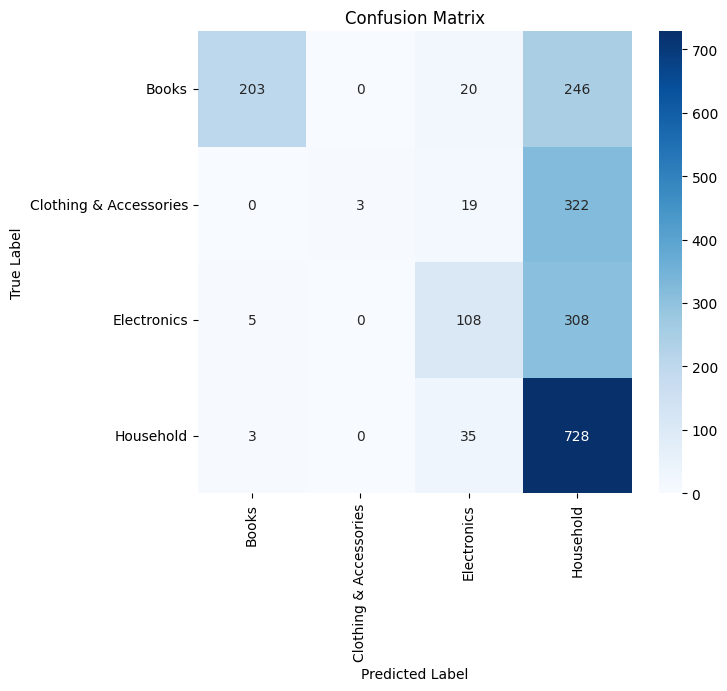

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


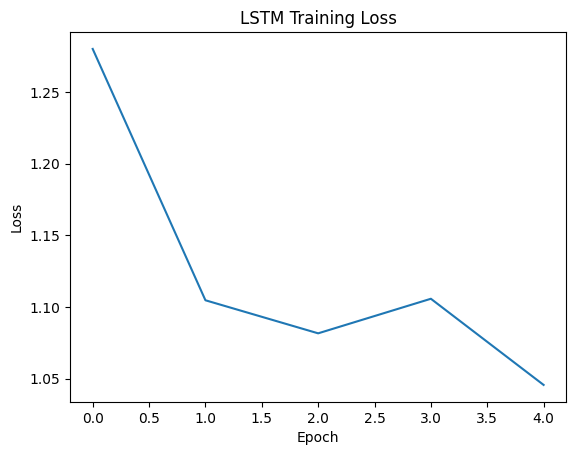

In [75]:
plt.plot(train_losses)
plt.title("LSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [76]:
# Buat folder jika belum ada
os.makedirs("lstm_model", exist_ok=True)

# Simpan bobot model
torch.save(model.state_dict(), "lstm_model/lstm_model.pth")

print("Model LSTM berhasil disimpan")


Model LSTM berhasil disimpan


In [77]:
import json

config = {
    "vocab_size": len(vocab),
    "embed_dim": 128,
    "hidden_dim": 128,
    "num_classes": num_labels,
    "max_len": MAX_LEN
}

with open("lstm_model/config.json", "w") as f:
    json.dump(config, f)

print("Config LSTM berhasil disimpan")


Config LSTM berhasil disimpan


In [78]:
import pickle

with open("lstm_model/vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

print("Vocab LSTM berhasil disimpan")

Vocab LSTM berhasil disimpan


In [79]:
import torch
import json
import pickle

# Load config
with open("lstm_model/config.json") as f:
    config = json.load(f)

# Load vocab
with open("lstm_model/vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

# Inisialisasi model
model = LSTMClassifier(
    config["vocab_size"],
    config["embed_dim"],
    config["hidden_dim"],
    config["num_classes"]
)

model.load_state_dict(torch.load("lstm_model/lstm_model.pth", map_location="cpu"))
model.eval()


LSTMClassifier(
  (embedding): Embedding(20002, 128, padding_idx=0)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)

In [80]:
!zip -r lstm_model.zip lstm_model

  adding: lstm_model/ (stored 0%)
  adding: lstm_model/lstm_model.pth (deflated 7%)
  adding: lstm_model/vocab.pkl (deflated 44%)
  adding: lstm_model/config.json (deflated 17%)


In [81]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [82]:
import shutil

shutil.move(
    '/content/lstm_model.zip',
    '/content/drive/MyDrive/lstm_model.zip'
)


'/content/drive/MyDrive/lstm_model.zip'

# BERT

In [ ]:
MODEL_NAME = "bert-base-multilingual-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(le.classes_)
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_ds = Dataset.from_dict({
    "text": X_train.tolist(),
    "labels": y_train.tolist()
})

test_ds = Dataset.from_dict({
    "text": X_test.tolist(),
    "labels": y_test.tolist()
})

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [41]:
training_args = TrainingArguments(
    output_dir="./bert_output",
    num_train_epochs=1,                 # 1 epoch per loop manual
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_steps=500,
    save_total_limit=1,
    fp16=torch.cuda.is_available(),
    report_to="none"
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer
)

trainer.train()


/tmp/ipython-input-2154087065.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,1.034100
100,0.496600
150,0.386900
200,0.358400
250,0.348100
300,0.333100
350,0.267600
400,0.295200
450,0.300400
500,0.218600


Step,Training Loss
50,1.034100
100,0.496600
150,0.386900
200,0.358400
250,0.348100
300,0.333100
350,0.267600
400,0.295200
450,0.300400
500,0.218600


TrainOutput(global_step=1000, training_loss=0.3330868434906006, metrics={'train_runtime': 10114.4155, 'train_samples_per_second': 0.791, 'train_steps_per_second': 0.099, 'total_flos': 526231560192000.0, 'train_loss': 0.3330868434906006, 'epoch': 1.0})

In [42]:
# Ambil log history
logs = trainer.state.log_history

# Pisahkan loss & accuracy
train_loss = []
eval_loss = []
eval_acc = []
steps = []

for log in logs:
    if "loss" in log and "epoch" in log:
        train_loss.append(log["loss"])
        steps.append(log.get("step", len(train_loss)))
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        eval_acc.append(log.get("eval_accuracy", None))


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


                        precision    recall  f1-score   support

                 Books       0.96      0.93      0.94       469
Clothing & Accessories       0.96      0.97      0.96       344
           Electronics       0.93      0.95      0.94       421
             Household       0.95      0.96      0.95       766

              accuracy                           0.95      2000
             macro avg       0.95      0.95      0.95      2000
          weighted avg       0.95      0.95      0.95      2000



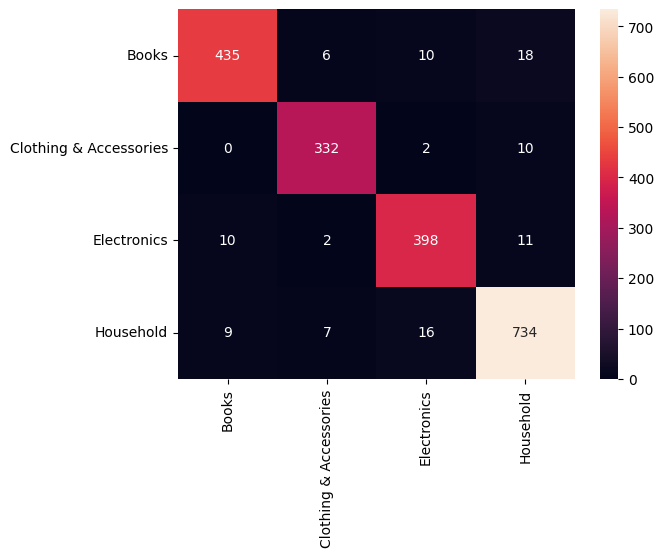

In [ ]:
pred = trainer.predict(test_ds)
y_pred = np.argmax(pred.predictions, axis=1)
probs = sc.softmax(pred.predictions, axis=1)

print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.show()

In [44]:
from sklearn.metrics import accuracy_score

# Re-calculate y_pred for BERT model
pred = trainer.predict(test_ds)
y_pred = np.argmax(pred.predictions, axis=1)

y_true = y_test.values # Define y_true
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy: 0.948


In [ ]:
print("Train loss:", train_loss)
print("Eval loss :", eval_loss)
print("Eval acc  :", eval_acc)

Train loss: [1.2874, 0.7381, 0.4885, 0.3727, 0.3327, 0.345, 0.267, 0.2899, 0.3093, 0.2305, 0.3012, 0.3432, 0.2275, 0.325, 0.2767, 0.2281, 0.2574, 0.235, 0.2342, 0.2889]
Eval loss : []
Eval acc  : []


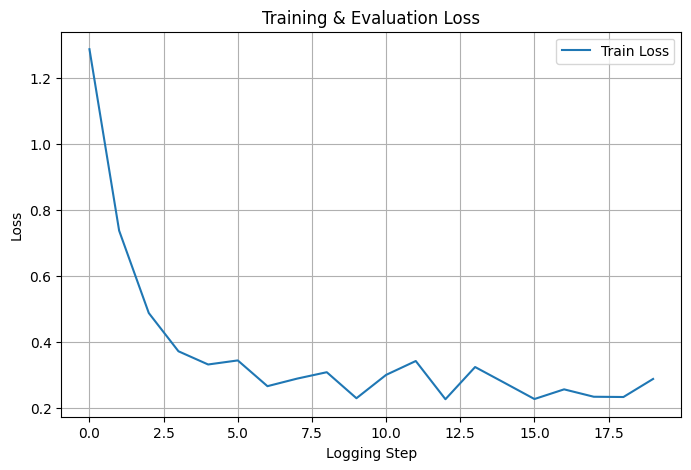

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Train Loss")
if len(eval_loss) > 0:
    plt.plot(eval_loss, label="Eval Loss")
plt.title("Training & Evaluation Loss")
plt.xlabel("Logging Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
pred = trainer.predict(test_ds)
y_pred = np.argmax(pred.predictions, axis=1)
probs = sc.softmax(pred.predictions, axis=1)

compare_df = pd.DataFrame({
    "Text": X_test.values,
    "Actual Label": [le.classes_[i] for i in y_test],
    "Predicted Label": [le.classes_[i] for i in y_pred],
    "Confidence": probs.max(axis=1)
})

display(compare_df.head(50))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


,Text,Actual Label,Predicted Label,Confidence
0,pioneer ts c in separate way component speaker...,Electronics,Electronics,0.994187
1,vivo y black gb ram gb storage with offers col...,Electronics,Electronics,0.994412
2,caroline at chh design hand painted ceramic ol...,Household,Household,0.996159
3,deckup engineered wood matte finish uniti door...,Household,Household,0.995691
4,floraware plastic revolving spice rack set ml ...,Household,Household,0.995930
5,the habits of highly effective people paperbac...,Books,Books,0.984341
6,nexusworld multi functional self draining orga...,Household,Household,0.996318
7,krystle men s woollen gloves black free size t...,Clothing & Accessories,Clothing & Accessories,0.996575
8,years chapterwise topicwise solved papers iit ...,Books,Books,0.984340
9,g tewani calculus for jee advanced cengage pub...,Books,Books,0.984214


In [ ]:
compare_df.to_csv("prediction_comparison.csv", index=False)
print("File prediction_comparison.csv berhasil disimpan")

File prediction_comparison.csv berhasil disimpan


In [ ]:
!zip -r bert_output.zip bert_output

  adding: bert_output/ (stored 0%)
  adding: bert_output/checkpoint-1000/ (stored 0%)
  adding: bert_output/checkpoint-1000/training_args.bin (deflated 54%)
  adding: bert_output/checkpoint-1000/model.safetensors (deflated 7%)
  adding: bert_output/checkpoint-1000/optimizer.pt (deflated 47%)
  adding: bert_output/checkpoint-1000/vocab.txt (deflated 48%)
  adding: bert_output/checkpoint-1000/scheduler.pt (deflated 61%)
  adding: bert_output/checkpoint-1000/tokenizer.json (deflated 69%)
  adding: bert_output/checkpoint-1000/config.json (deflated 56%)
  adding: bert_output/checkpoint-1000/tokenizer_config.json (deflated 75%)
  adding: bert_output/checkpoint-1000/rng_state.pth (deflated 26%)
  adding: bert_output/checkpoint-1000/trainer_state.json (deflated 76%)
  adding: bert_output/checkpoint-1000/special_tokens_map.json (deflated 42%)


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import shutil

shutil.move(
    '/content/bert_output.zip',
    '/content/drive/MyDrive/bert_output.zip'
)


'/content/drive/MyDrive/bert_output.zip'

In [ ]:
train_df, test_df = train_test_split(
    df_sample,
    test_size=0.2,
    stratify=df_sample["label"],
    random_state=42
)

print("Train size:", len(train_df))
print("Test size :", len(test_df))

train_df[["Label", "Text"]].to_csv(
    "/content/drive/MyDrive/train_8000.csv",
    index=False,
    encoding="utf-8"
)

test_df[["Label", "Text"]].to_csv(
    "/content/drive/MyDrive/test_2000.csv",
    index=False,
    encoding="utf-8"
)

print("train_8000.csv & test_2000.csv berhasil disimpan")

Train size: 8000
Test size : 2000
train_8000.csv & test_2000.csv berhasil disimpan


In [ ]:
train_df, test_df = train_test_split(
    df_sample,
    test_size=0.2,
    stratify=df_sample["label"],
    random_state=42
)

print("Train:", len(train_df))
print("Test :", len(test_df))

Train: 8000
Test : 2000


In [ ]:
train_df[["Label", "Text"]].to_csv(
    "/content/drive/MyDrive/train_8000.csv",
    index=False,
    encoding="utf-8"
)

test_df[["Label", "Text"]].to_csv(
    "/content/drive/MyDrive/test_2000.csv",
    index=False,
    encoding="utf-8"
)

print("train_8000.csv & test_2000.csv berhasil disimpan")

train_8000.csv & test_2000.csv berhasil disimpan


In [ ]:
train_df[["Label", "label", "Text"]].to_csv(
    "/content/drive/MyDrive/train_8000_encoded.csv",
    index=False,
    encoding="utf-8"
)

test_df[["Label", "label", "Text"]].to_csv(
    "/content/drive/MyDrive/test_2000_encoded.csv",
    index=False,
    encoding="utf-8"
)

print("CSV encoded berhasil disimpan")

CSV encoded berhasil disimpan


# DistilBert

In [ ]:
MODEL_NAME = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(le.classes_)
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_ds = Dataset.from_dict({
    "text": X_train.tolist(),
    "labels": y_train.tolist()
})

test_ds = Dataset.from_dict({
    "text": X_test.tolist(),
    "labels": y_test.tolist()
})

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    output_dir="./distilbert_output",
    num_train_epochs=1,                 # 1 epoch per loop manual
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_steps=500,
    save_total_limit=1,
    fp16=torch.cuda.is_available(),
    report_to="none"
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer
)

trainer.train()

/tmp/ipython-input-785867814.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,0.998000
100,0.429600
150,0.315800
200,0.329500
250,0.261700
300,0.278100
350,0.225000
400,0.248700
450,0.271800
500,0.215900


Step,Training Loss
50,0.998000
100,0.429600
150,0.315800
200,0.329500
250,0.261700
300,0.278100
350,0.225000
400,0.248700
450,0.271800
500,0.215900


TrainOutput(global_step=1000, training_loss=0.29557548141479495, metrics={'train_runtime': 5616.4234, 'train_samples_per_second': 1.424, 'train_steps_per_second': 0.178, 'total_flos': 264944246784000.0, 'train_loss': 0.29557548141479495, 'epoch': 1.0})

In [ ]:
# Ambil log history
logs = trainer.state.log_history

# Pisahkan loss & accuracy
train_loss = []
eval_loss = []
eval_acc = []
steps = []

for log in logs:
    if "loss" in log and "epoch" in log:
        train_loss.append(log["loss"])
        steps.append(log.get("step", len(train_loss)))
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        eval_acc.append(log.get("eval_accuracy", None))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


                        precision    recall  f1-score   support

                 Books       0.96      0.93      0.95       469
Clothing & Accessories       0.97      0.98      0.97       344
           Electronics       0.95      0.94      0.95       421
             Household       0.95      0.97      0.96       766

              accuracy                           0.96      2000
             macro avg       0.96      0.96      0.96      2000
          weighted avg       0.96      0.96      0.96      2000



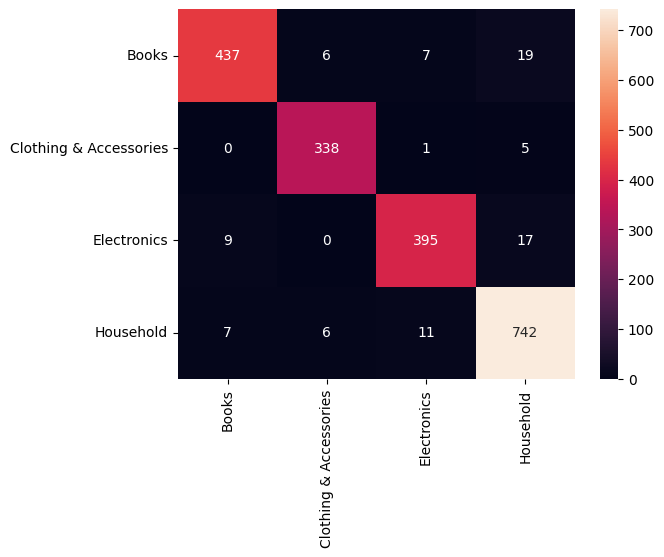

In [ ]:
pred = trainer.predict(test_ds)
y_pred = np.argmax(pred.predictions, axis=1)
probs = sc.softmax(pred.predictions, axis=1)

print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

y_true = y_test.values # Define y_true
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.956


In [ ]:
print("Train loss:", train_loss)

Train loss: [0.998, 0.4296, 0.3158, 0.3295, 0.2617, 0.2781, 0.225, 0.2487, 0.2718, 0.2159, 0.1912, 0.304, 0.1835, 0.2682, 0.2624, 0.1888, 0.2355, 0.22, 0.245, 0.239]


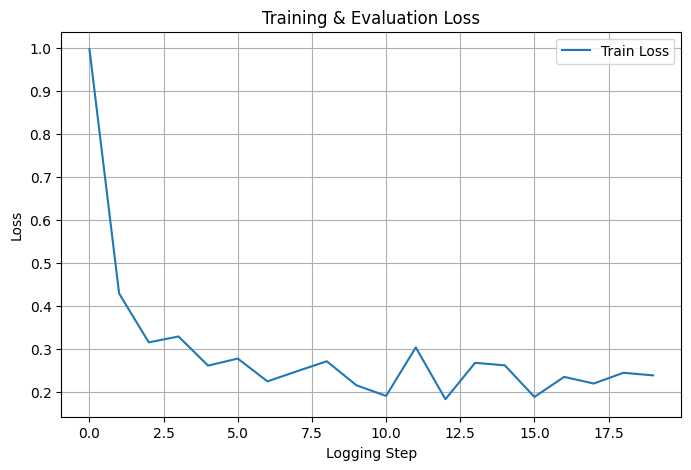

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Train Loss")
if len(eval_loss) > 0:
    plt.plot(eval_loss, label="Eval Loss")
plt.title("Training & Evaluation Loss")
plt.xlabel("Logging Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
pred = trainer.predict(test_ds)
y_pred = np.argmax(pred.predictions, axis=1)
probs = sc.softmax(pred.predictions, axis=1)

compare_df = pd.DataFrame({
    "Text": X_test.values,
    "Actual Label": [le.classes_[i] for i in y_test],
    "Predicted Label": [le.classes_[i] for i in y_pred],
    "Confidence": probs.max(axis=1)
})

display(compare_df.head(50))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


,Text,Actual Label,Predicted Label,Confidence
0,pioneer ts c in separate way component speaker...,Electronics,Electronics,0.992109
1,vivo y black gb ram gb storage with offers col...,Electronics,Electronics,0.993881
2,caroline at chh design hand painted ceramic ol...,Household,Household,0.993599
3,deckup engineered wood matte finish uniti door...,Household,Household,0.993101
4,floraware plastic revolving spice rack set ml ...,Household,Household,0.993698
5,the habits of highly effective people paperbac...,Books,Books,0.989885
6,nexusworld multi functional self draining orga...,Household,Household,0.993648
7,krystle men s woollen gloves black free size t...,Clothing & Accessories,Clothing & Accessories,0.994331
8,years chapterwise topicwise solved papers iit ...,Books,Books,0.990012
9,g tewani calculus for jee advanced cengage pub...,Books,Books,0.989866


In [ ]:
compare_df.to_csv("prediction_comparison1.csv", index=False)
print("File prediction_comparison1.csv berhasil disimpan")

File prediction_comparison1.csv berhasil disimpan


In [ ]:
!zip -r distilbert_output.zip distilbert_output

  adding: distilbert_output/ (stored 0%)
  adding: distilbert_output/checkpoint-1000/ (stored 0%)
  adding: distilbert_output/checkpoint-1000/training_args.bin (deflated 54%)
  adding: distilbert_output/checkpoint-1000/model.safetensors (deflated 8%)
  adding: distilbert_output/checkpoint-1000/optimizer.pt (deflated 23%)
  adding: distilbert_output/checkpoint-1000/vocab.txt (deflated 53%)
  adding: distilbert_output/checkpoint-1000/scheduler.pt (deflated 61%)
  adding: distilbert_output/checkpoint-1000/tokenizer.json (deflated 71%)
  adding: distilbert_output/checkpoint-1000/config.json (deflated 50%)
  adding: distilbert_output/checkpoint-1000/tokenizer_config.json (deflated 75%)
  adding: distilbert_output/checkpoint-1000/rng_state.pth (deflated 26%)
  adding: distilbert_output/checkpoint-1000/trainer_state.json (deflated 75%)
  adding: distilbert_output/checkpoint-1000/special_tokens_map.json (deflated 42%)
